In [59]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [60]:
def alpha(t: float, params: dict) -> float:
    a_0 = params["alpha_0"]
    a_1 = params["alpha_1"]
    lambda_0 = params["lambda"]
    return a_0 + a_1*np.exp(-lambda_0*t)

def f(x, v, t, params: dict):
    return v

def g(x, v, t, params: dict):
    g = params["g"]
    R = params["R"]
    return (-g/R) * np.sin(x) - alpha(t, params)*v

In [61]:
def trapez(x_n: float, v_n: float, dt: float, t: float, params: dict) -> (float, float):
    # t is current t.

    MAX_ITER = 200
    TOL = 1e-10

    g_val = params["g"]
    R = params["R"]
    t_n_plus_1 = t + dt

    alpha_n_plus_1 = alpha(t_n_plus_1, params)

    f_n = f(x_n, v_n, t, params)
    g_n = g(x_n, v_n, t, params)

    x_old = x_n
    v_old = v_n

    for iters_counter in range(MAX_ITER):
        f_k = f(x_old, v_old, t_n_plus_1, params)
        g_k = g(x_old, v_old, t_n_plus_1, params)

        F = x_old - x_n - (dt / 2.0) * (f_n + f_k)
        G = v_old - v_n - (dt / 2.0) * (g_n + g_k)

        a11 = 1.0 - (dt / 2.0) * 0.0
        a12 = -(dt / 2.0) * 1.0
        a21 = -(dt / 2.0) * (-g_val / R * np.cos(x_old))
        a22 = 1.0 - (dt / 2.0) * (-alpha_n_plus_1)

        det = a11 * a22 - a12 * a21

        # if abs(det) < 1e-18:
        #     print("Warning: Jacobian determinant close to zero in trapez method.")
        #     break

        delta_x = (G * a12 - F * a22) / det
        delta_v = (F * a21 - G * a11) / det

        x_new = x_old + delta_x
        v_new = v_old + delta_v

        if abs(delta_x) < TOL and abs(delta_v) < TOL:
            # Hit tolerance limit
            break

        x_old = x_new
        v_old = v_new

    return x_new, v_new

In [62]:
def RK2(x_n: float, v_n: float, dt: float, t_n: float, params: dict) -> (float, float):
    k1_x = f(x_n, v_n, t_n, params)
    k1_v = g(x_n, v_n, t_n, params)

    t_k2 = t_n + dt
    x_k2 = x_n + dt * k1_x
    v_k2 = v_n + dt * k1_v
    k2_x = f(x_k2, v_k2, t_k2, params)
    k2_v = g(x_k2, v_k2, t_k2, params)

    x_n_plus_1 = x_n + (dt / 2.0) * (k1_x + k2_x)
    v_n_plus_1 = v_n + (dt / 2.0) * (k1_v + k2_v)

    return x_n_plus_1, v_n_plus_1

In [116]:
def solve(params: dict):
    fig_w = 8
    fig_rows = 5
    axs = plt.subplots(fig_rows, 2, figsize=(2*fig_w, fig_rows*fig_w))[1]

    print(f"tmax={int(params['t_max'])}")

    for method_idx, method in enumerate(params["methods"]):
        for tol_idx, tol in enumerate(params["tols"]):
            t_max = params["t_max"]
            dt = params["start_dt"]
            S = params["S"]
            p = params["p"]

            t = np.array([0.0], dtype=float)
            dts = np.zeros_like(t, dtype=float)

            x = np.zeros_like(t)
            v = np.zeros_like(t)

            dts[0] = dt
            x[0] = params["theta_0"]
            v[0] = params["v_0"]

            idx = 0
            MAX_ITERS = 100000
            for iteration in range(MAX_ITERS):
                current_t = t[idx]

                # One long step
                x1_np2, v1_np2 = method(x[idx], v[idx], 2.0*dt, current_t, params)

                x2_np1, v2_np1 = method(x[idx], v[idx], dt, current_t, params)
                x2_np2, v2_np2 = method(x2_np1, v2_np1, dt, dt+current_t, params)

                Ex = (x2_np2 - x1_np2) / (2**p - 1)
                Ev = (v2_np2 - v1_np2) / (2**p - 1)

                max_err = max(abs(Ex), abs(Ev))

                if max_err < tol:
                    current_t = current_t + 2 * dt
                    t = np.append(t, current_t)
                    dts = np.append(dts, dt)
                    x = np.append(x, x2_np2)
                    v = np.append(v, v2_np2)

                    if current_t >= t_max:
                        # Hit t_max limit
                        break

                    idx += 1

                # New delta t
                if max_err < 1e-20:
                    dt_factor = 2.0
                else:
                    dt_factor = np.power(S * tol / max_err, 1.0 / (p + 1.0))

                dt = dt * np.clip(dt_factor, 0.0, 2.0)

            print(f"{params['method_names'][method_idx]}, tol={params['tols'][tol_idx]}, nots={iteration}")

            ax = axs[0, method_idx]
            ax.set_title(params["method_names"][method_idx] + ", $t_{max}$ = " f"{int(t_max)}")

            ax.plot(t, v, label=f"tol = {tol}")
            ax.set_xlabel("t")
            ax.set_ylabel("$v_{\\theta}(t)$")
            ax.legend()
            ax.grid(True)

            ax = axs[1, method_idx]
            ax.plot(t, x, label=f"tol = {tol}")
            ax.set_xlabel("t")
            ax.set_ylabel("${\\theta}(t)$")
            ax.legend()
            ax.grid(True)

            ax = axs[2, method_idx]
            ax.plot(t, dts, label=f"tol = {tol}")
            ax.set_xlabel("t")
            ax.set_ylabel("${\Delta}t(t)$")
            ax.legend()
            ax.grid(True)

            ax = axs[3, method_idx]
            ax.plot(x, v, label=f"tol = {tol}")
            ax.set_xlabel("${\\theta}(t)$")
            ax.set_ylabel("$v_{\\theta}(t)$")
            ax.legend()
            ax.grid(True)

            ax = axs[4, tol_idx]
            ax.plot(x, v, label=f"{params['short_method_names'][method_idx]} tol = {tol}")
            ax.set_xlabel("${\\theta}(t)$")
            ax.set_ylabel("$v_{\\theta}(t)$")
            ax.legend()
            ax.grid(True)

    print()




tmax=10
RK2, tol=0.01, nots=408
RK2, tol=1e-05, nots=617
Metoda trapezów, tol=0.01, nots=45
Metoda trapezów, tol=1e-05, nots=246

tmax=30
RK2, tol=0.01, nots=488
RK2, tol=1e-05, nots=1143
Metoda trapezów, tol=0.01, nots=98
Metoda trapezów, tol=1e-05, nots=673

tmax=150
RK2, tol=0.01, nots=762
RK2, tol=1e-05, nots=1500
Metoda trapezów, tol=0.01, nots=114
Metoda trapezów, tol=1e-05, nots=801



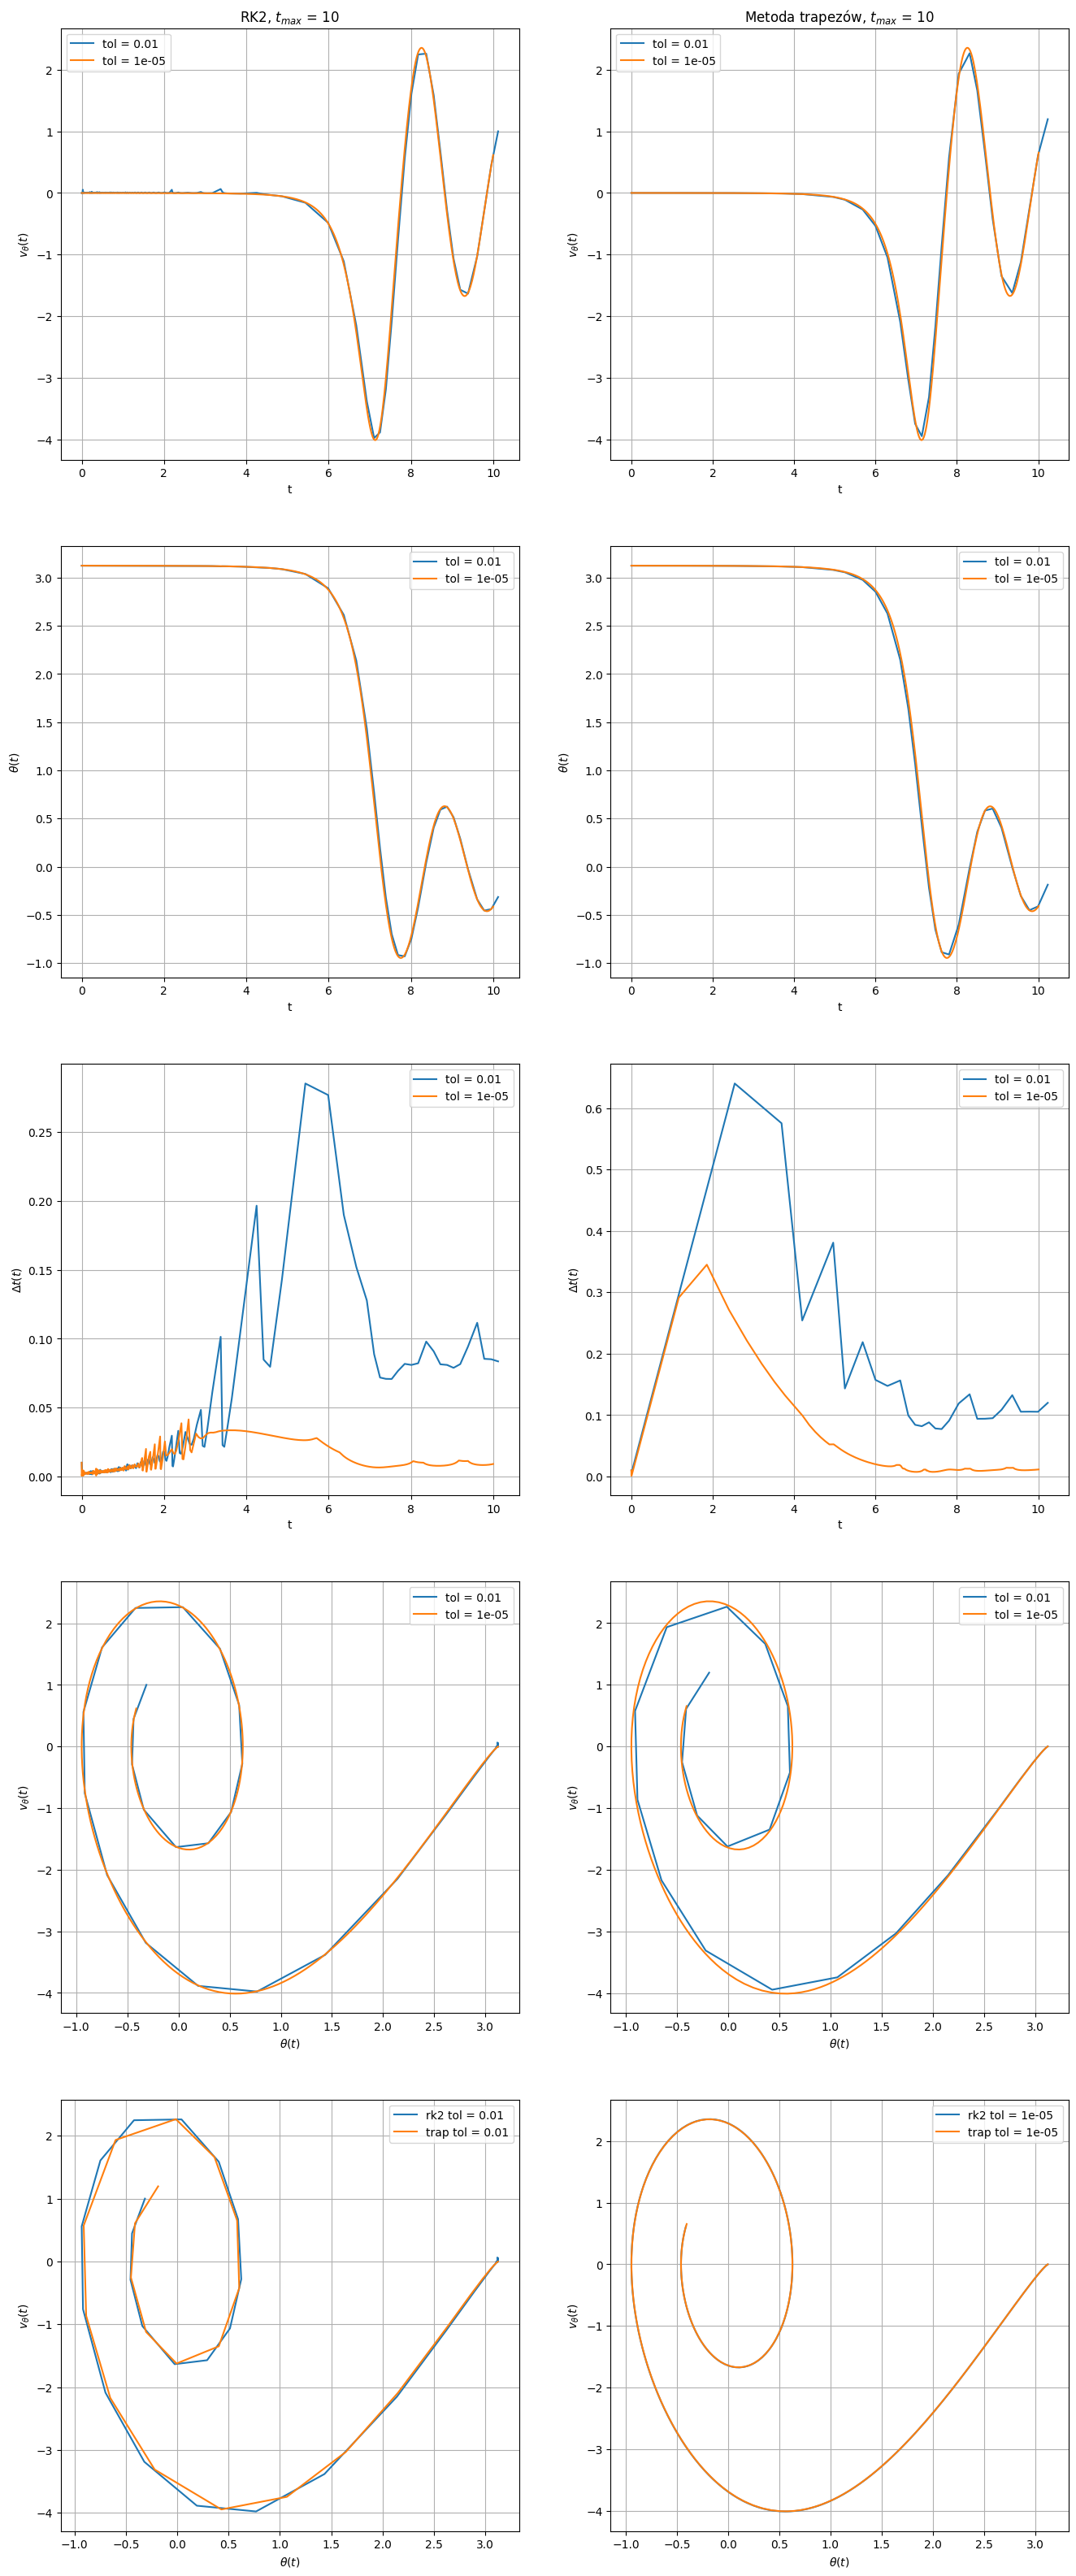

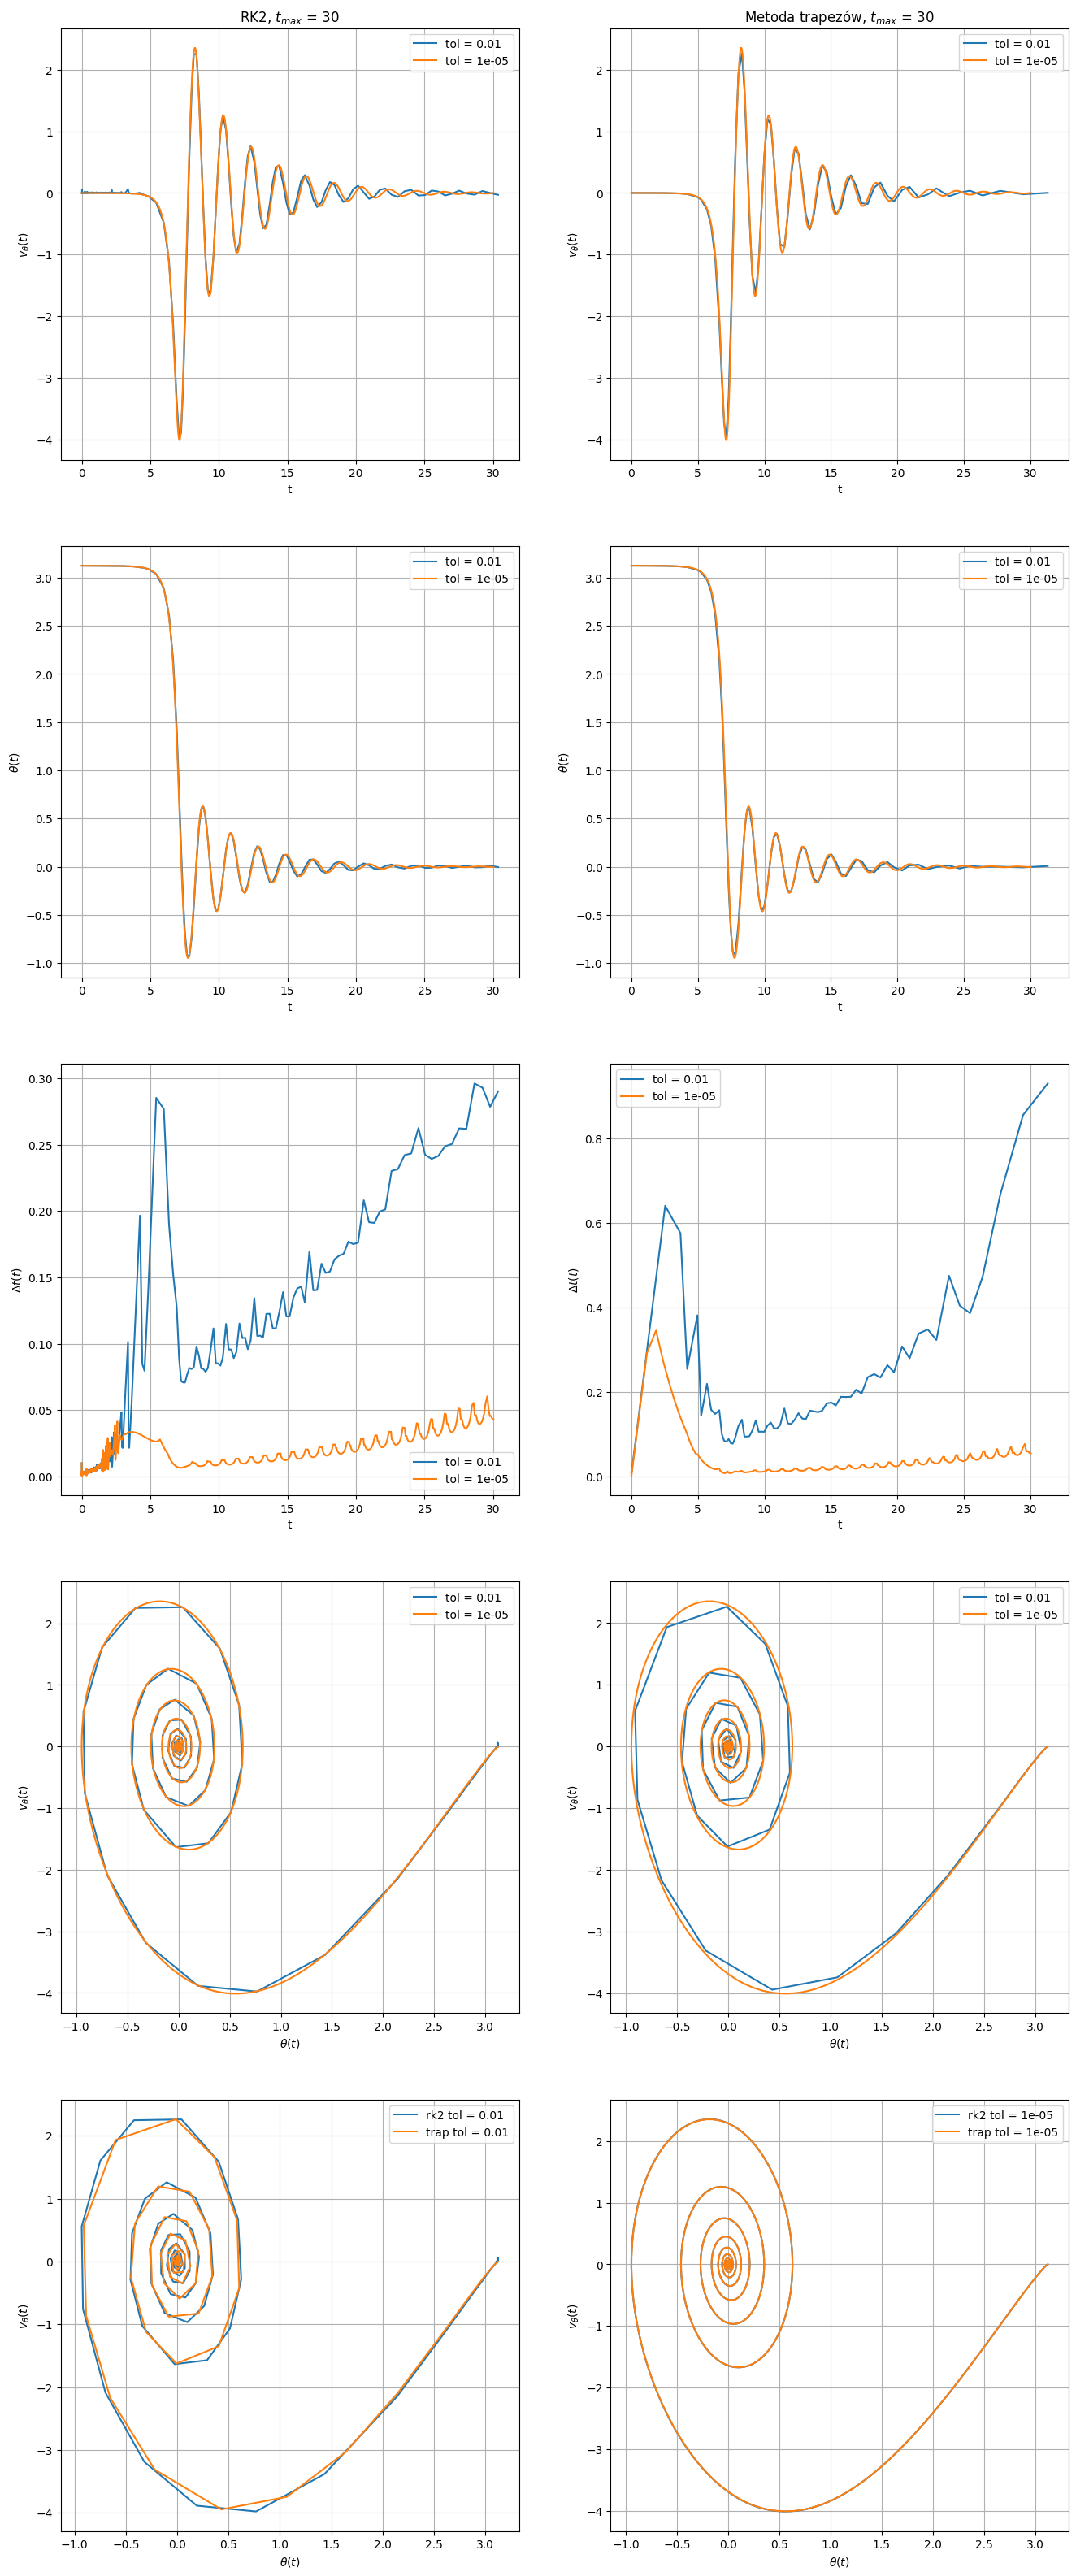

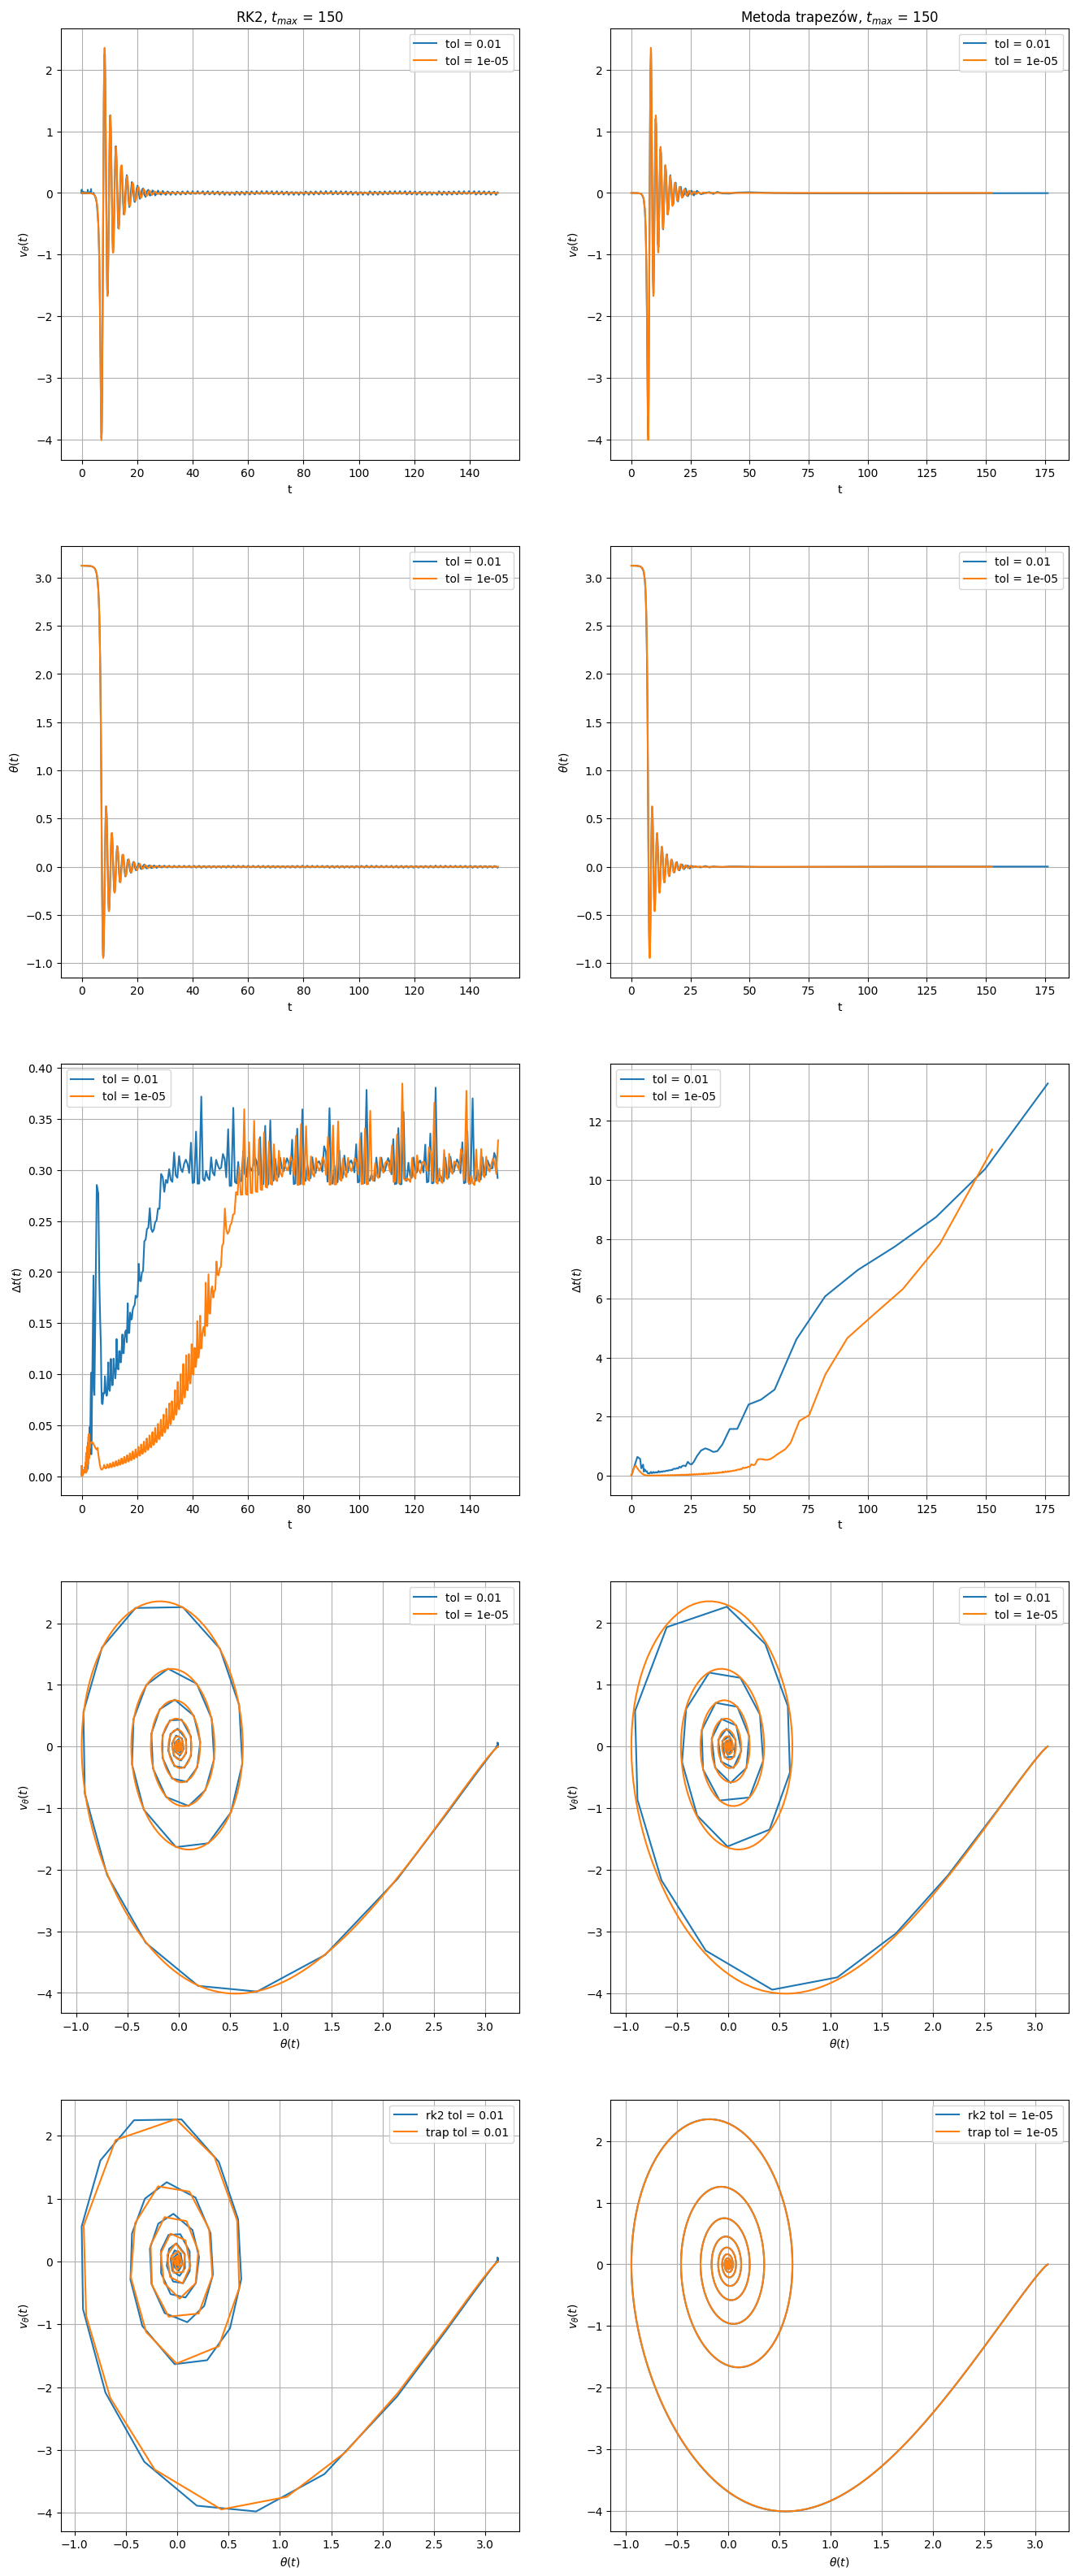

In [118]:
starting_params = [
    {
        "alpha_0": 0.5,
        "alpha_1": 1000.0,
        "lambda": 1.0,
        "g": 9.81,
        "R": 1.0,
        "m": 1.0,
        "tols": [1e-2, 1e-5],
        "theta_0": np.deg2rad(179),
        "v_0": 0,
        "start_dt": 0.01,
        "S": 0.75,
        "p": 2,
        "t_max": 10.0,

        "methods": [RK2, trapez],
        "method_names": ["RK2", "Metoda trapezów"],
        "short_method_names": ["rk2", "trap"],
    },


    {
        "alpha_0": 0.5,
        "alpha_1": 1000.0,
        "lambda": 1.0,
        "g": 9.81,
        "R": 1.0,
        "m": 1.0,
        "tols": [1e-2, 1e-5],
        "theta_0": np.deg2rad(179),
        "v_0": 0,
        "start_dt": 0.01,
        "S": 0.75,
        "p": 2,
        "t_max": 30.0,

        "methods": [RK2, trapez],
        "method_names": ["RK2", "Metoda trapezów"],
        "short_method_names": ["rk2", "trap"],
    },


    {
        "alpha_0": 0.5,
        "alpha_1": 1000.0,
        "lambda": 1.0,
        "g": 9.81,
        "R": 1.0,
        "m": 1.0,
        "tols": [1e-2, 1e-5],
        "theta_0": np.deg2rad(179),
        "v_0": 0,
        "start_dt": 0.01,
        "S": 0.75,
        "p": 2,
        "t_max": 150.0,

        "methods": [RK2, trapez],
        "method_names": ["RK2", "Metoda trapezów"],
        "short_method_names": ["rk2", "trap"],
    },

]

for params in starting_params:
    solve(params)